## Cases studies
This notebook contains the code for the case studies in the application section of the paper <em>"Frequency Regulation with Storage: On Losses and Profits"</em>, available at https://doi.org/10.1016/j.ejor.2024.03.022 and https://arxiv.org/pdf/2306.02987v2.pdf.

In [1]:
## load python libraries
# data analysis
import pandas as pd
import numpy as np
import scipy.optimize as sopt
import scipy.stats as sts
from datetime import datetime, timedelta
# static plotting
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib as mpl

### Load frequency deviation data to construct Figure 7.

In [2]:
# load normalized frequency deviation data
dlt = pd.read_hdf('delta_10s.h5')
# restrict dataframe to 2017-19 data
dlt = dlt.loc[dlt.index.year.isin([2017, 2018, 2019])]
MAD = abs(dlt).mean().values[0]

In [3]:
# check the mean value of the frequency deviations over all days
print('The average frequency deviation over all days is '+str(round(10**5*dlt.delta.mean(),2))+'e-5.')

The average frequency deviation over all days is 3.64e-5.


In [4]:
# check mean absolute deviation on each day
dlt_abs = abs(dlt.delta)
mad_day = dlt_abs.resample('1D').mean()
print('The minimum, average, and maximum mean absolute deviations are '+str(round(max(mad_day),4))+', '+\
     str(round(np.mean(mad_day),4))+', and '+str(round(min(mad_day),4))+', respectively.')
print('The mean absolute deviation is greater than 0.1 on ' + str(round(100*np.mean(mad_day > 0.1),1)) + \
      '% of all days and greater than 0.111 on '+str(round(100*np.mean(mad_day > 0.111),1)) + '% of all days.')
# by how much does the average mean absolute deviation over all days change
# if we cap the maximum mean absolute deviation on any day at 0.1?
mad_day_cap = mad_day
mad_day_cap.loc[mad_day_cap > 0.1] = 0.1
MAD_cap = np.mean(mad_day_cap)
print('If the maximum mean absolute deviation on any day is capped at 0.1, then the average of the mean absolute devation over all days reduces to '\
      +str(round(MAD_cap,4))+'.')

The minimum, average, and maximum mean absolute deviations are 0.1598, 0.0816, and 0.0577, respectively.
The mean absolute deviation is greater than 0.1 on 3.3% of all days and greater than 0.111 on 1.0% of all days.
If the maximum mean absolute deviation on any day is capped at 0.1, then the average of the mean absolute devation over all days reduces to 0.0812.


In [5]:
# define the logistic approximation of the empirical cumulative distribution function given the mean absolute deviation
# and assuming that the mean value is zero
def F(x, MAD = MAD):
    theta = 2*np.log(2)/MAD
    return 1/(1 + np.exp(-theta*x))
x = np.linspace(-1,1,2001)

In [6]:
# compute maximum error between F and the empirical cdf and between F and Fcap
dlt_x = dlt.sort_values(by = 'delta').delta.values
dlt_p = np.linspace(1/(2*len(dlt)),1,len(dlt))
print('The maximum error between F and the empirical cumulative distribution is '+str(round(max(abs(F(dlt_x) - dlt_p)),3))+'.')
print('The maximum error between F and Fcap is '+str(round(max(abs(F(dlt_x) - F(dlt_x, MAD_cap))),4))+'.')

The maximum error between F and the empirical cumulative distribution is 0.018.
The maximum error between F and Fcap is 0.0009.


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


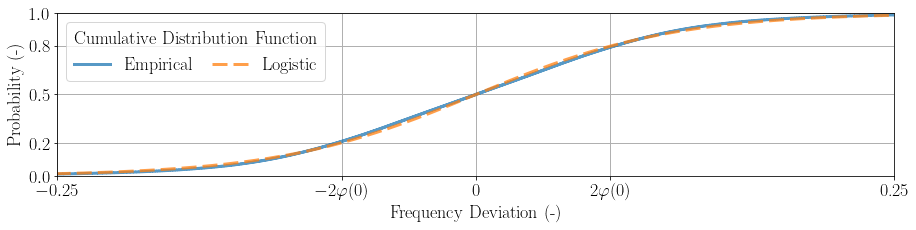

In [7]:
transp = 0.75
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)
# Plot
fig = plt.figure(figsize=[15, 3])
plt.rcParams.update({'font.size': 18})
plt.plot(dlt_x, dlt_p,\
    linewidth = 3, alpha = transp, linestyle = '-', label = 'Empirical', color = 'tab:blue')
plt.plot(x, F(x),\
    linewidth = 3, alpha = transp, linestyle = (0, (5,2)), label = 'Logistic', color = 'tab:orange')
plt.grid(linewidth = 1)
plt.xticks([-0.5, -0.25, -0.08, 0, 0.08, 0.25, 0.5], ('$-0.5$', '$-0.25$', r'$-2\varphi(0)$', '0', r'$2\varphi(0)$', '0.25', '0.5'))
plt.yticks([0, 0.2, 0.5, 0.8, 1])
plt.xlabel("Frequency Deviation (-)")
plt.ylabel('Probability (-)')
plt.legend(loc = 'upper left', title = 'Cumulative Distribution Function', ncol = 2, columnspacing = 1, fontsize = 18, title_fontsize = 18)
plt.axis((-0.25, 0.25, 0, 1))
plt.savefig('Pics/F_sig.pdf', bbox_inches = 'tight')

### Load price data to construct Figure 6.

In [8]:
# load availability, retail, and wholesale prices
pa = pd.read_hdf('pa.h5')
pb = pd.read_hdf('pb.h5')
pdel = pd.read_hdf('pd.h5')
# restrict dataframes to 2019 data
year = 2019
pa = pa.loc[pa.index.year.isin([year])]
pb = pb.loc[pb.index.year.isin([year])]
pdel = pdel.loc[pdel.index.year.isin([year])]
# prices have 30 min resolution, aggregate dlt to 30 min resolution
dlt_30 = dlt.loc[dlt.index.year == 2019].resample('30T').mean()

In [9]:
# check minimum prices and the average value of pd x del
print('The minimum availability, delivery, and retail prices are '+str(round(100*min(pa.pa),2))+', '+str(round(100*min(pdel.pd),2))+\
     ', and '+str(round(100*min(pb.Flat),2))+' cts/kWh.')
print('The average value of delta x pd is '+str(round(10**5*np.mean(pdel.pd * dlt_30.delta),2))+'e-5.')

The minimum availability, delivery, and retail prices are 0.41, -2.49, and 14.5 cts/kWh.
The average value of delta x pd is -8.77e-5.


In [10]:
# -- check expected daily costs. In order to calculate the expectations, we assume that delta is unknown, but that all prices are known.
# compute half-hourly costs
cr = pa.pa
# aggregate to daily costs
cr = cr.resample('1D').mean()
cb_retail = pb.Flat.resample('1D').mean()
cb_wholesale = pdel.pd.resample('1D').mean()
# check minimum costs
print('The minimum daily average price of regulation power is '+str(round(100*min(cr),2))+'cts/kWh.')
print('The minimum daily average retail market and wholesale market prices of electrictiy are '+str(round(100*min(cb_retail),2))+'cts/kWh and '+\
     str(round(100*min(cb_wholesale),2))+'cts/kWh, respectively.')

The minimum daily average price of regulation power is 0.41cts/kWh.
The minimum daily average retail market and wholesale market prices of electrictiy are 14.5cts/kWh and 0.37cts/kWh, respectively.


In [11]:
# compute cost ratios and probability
cr_cb_retail = cr/cb_retail
cr_cb_wholesale = cr/cb_wholesale
cr_cb_p = np.linspace(1/(2*len(cr)),1,len(cr))
# print minimum, average, and maximum values
print('Retail cr/cb')
print('Minimum: '+str(round(min(cr_cb_retail),3)))
print('Average: '+str(round(cr_cb_retail.mean(),3)))
print('Maximum: '+str(round(max(cr_cb_retail),3)))
print('Wholesale cr/cb')
print('Minimum: '+str(round(min(cr_cb_wholesale),3)))
print('Average: '+str(round(cr_cb_wholesale.mean(),3)))
print('Maximum: '+str(round(max(cr_cb_wholesale),3)))

Retail cr/cb
Minimum: 0.026
Average: 0.059
Maximum: 0.133
Wholesale cr/cb
Minimum: 0.07
Average: 0.251
Maximum: 2.168


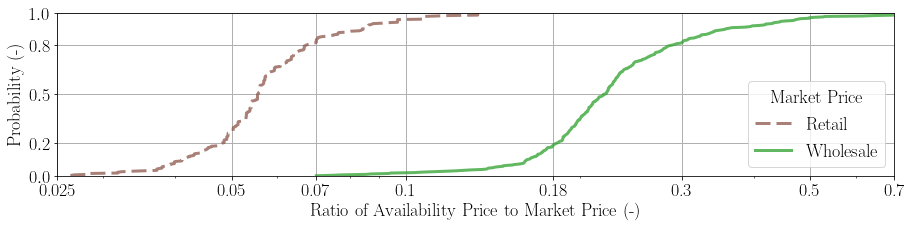

In [12]:
transp = 0.75
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)
# Plot
fig = plt.figure(figsize=[15, 3])
plt.rcParams.update({'font.size': 18})
plt.semilogx(cr_cb_retail.sort_values(), cr_cb_p,\
    linewidth = 3, alpha = transp, linestyle = (0, (5,2)), label = 'Retail', color = 'tab:brown')
plt.semilogx(cr_cb_wholesale.sort_values(), cr_cb_p,\
    linewidth = 3, alpha = transp, linestyle = '-', label = 'Wholesale', color = 'tab:green')
plt.grid(linewidth = 1)
x_ticks = [0.025, 0.05, 0.07, 0.1, 0.18, 0.3, 0.5, 0.7]
x_ticks_string = [str(x) for x in x_ticks]
plt.xticks(x_ticks, x_ticks_string)
plt.yticks([0, 0.2, 0.5, 0.8, 1])
plt.xlabel("Ratio of Availability Price to Market Price (-)")
plt.ylabel('Probability (-)')
plt.legend(loc = 'lower right', title = 'Market Price', ncol = 1, fontsize = 18, title_fontsize = 18)
plt.axis((0.025, 0.7, 0, 1))
plt.savefig('Pics/cr_cb.pdf', bbox_inches = 'tight')

### Compute the marginal increase in expected power loss $m$ to construct Figure 2.

In [13]:
def m2(n, MAD = MAD):
    return 2*(1 - n)/(1 + n)*MAD/2
def m3(n, MAD = MAD):
    return 1 - 1/( 1 + (1/n - 1)*MAD/2 )
# numerical solution with sigmoid approximation
def phi(z, MAD = MAD):
    theta = 2*np.log(2)/MAD
    return np.log(1 + np.exp(theta*z))/theta
def m(n, tol = 1e-6):
    # find the root of this function
    def h(z):
         return (1/n - 1) * phi(-z) - z
    # with bisection
    return sopt.bisect(h, 0, 1, xtol = tol)

In [14]:
# Efficiencies
step = 0.01
N = np.arange(0.35, 1+step, step)
N = np.round(N,2)
M = []
for n in N[:-1]:
    M.append(m(n))
M.append(0)

In [15]:
# check specific values of m2 and m
m_df = pd.Series(data = M, index = N)
print('For eta^+eta^- = 0.60, m - m2 = '+str( round(10**4*(m_df[0.6] - m2(0.6)),2))+'e-4.')
for nval in [0.35, 0.60, 0.85]:
    print('eta^+eta^- = '+str(nval)+', m = '+str(round(100*m_df[nval], 2))+'e-2.')

For eta^+eta^- = 0.60, m - m2 = 4.59e-4.
eta^+eta^- = 0.35, m = 4.3e-2.
eta^+eta^- = 0.6, m = 2.09e-2.
eta^+eta^- = 0.85, m = 0.66e-2.


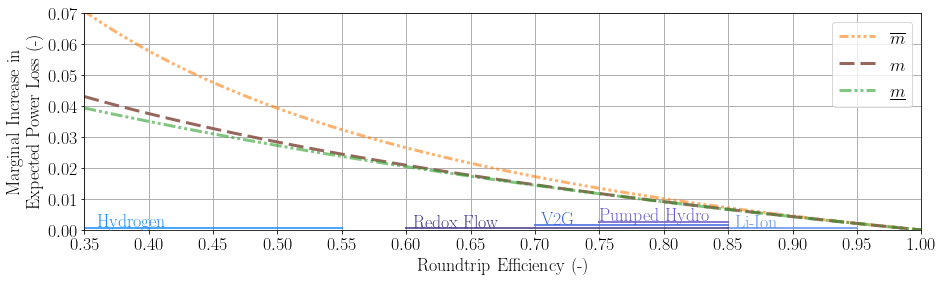

In [16]:
transp = 0.9
transp_t = 0.8
transp_b = 0.6
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)
# Plot
fig = plt.figure(figsize=[15, 4])
plt.rcParams.update({'font.size': 18})
# Distributions
plt.plot(N, m3(N), linewidth = 3, alpha = transp_b, linestyle = (0, (3, 1, 1, 1, 1, 1, 1, 1)), label = r'$\overline m$', color = 'tab:orange')
plt.plot(N, M, linewidth = 3, alpha = transp, linestyle = (0, (5,2)), label = '$m$', color = 'tab:brown')
plt.plot(N, m2(N), linewidth = 3, alpha = transp_b, linestyle = (0, (4, 1, 1, 1, 1, 1)), label = r'$\underline m$', color = 'tab:green')
# Technologies
# Li-Ion
plt.plot([0.85, 0.95], [0.0005, 0.0005], linewidth = 2, alpha = transp_t, color = 'cornflowerblue')
plt.annotate('Li-Ion', (0.855, 0.001), color = 'cornflowerblue')
# PHS
plt.plot([0.75, 0.85], [0.0025, 0.0025], linewidth = 2, alpha = transp_t, color = 'slateblue')
plt.annotate('Pumped Hydro', (0.75, 0.003), color = 'slateblue')
# V2G
plt.plot([0.70, 0.85], [0.0015, 0.0015], linewidth = 2, alpha = transp_t, color = 'royalblue')
plt.annotate('V2G', (0.705, 0.002), color = 'royalblue')
# Redoxflow
plt.plot([0.60, 0.85], [0.0005, 0.0005], linewidth = 2, alpha = transp_t, color = 'darkslateblue')
plt.annotate('Redox Flow', (0.605, 0.001), color = 'darkslateblue')
# H2
plt.plot([0.35, 0.55], [0.0005, 0.0005], linewidth = 2, alpha = transp_t, color = 'dodgerblue')
plt.annotate('Hydrogen', (0.36, 0.001), color = 'dodgerblue')
# Formatting
plt.grid(linewidth = 1)
plt.xticks(np.arange(0.35, 1.05, 0.05))
y_ticks = np.arange(0,0.072, 0.01)
y_ticks_string = [str(y) for y in y_ticks]
plt.yticks(y_ticks)
plt.xlabel("Roundtrip Efficiency (-)")
plt.ylabel('Marginal Increase in \n Expected Power Loss (-)')
plt.legend()
plt.axis((0.35, 1, 0, 0.07))
plt.savefig('Pics/m.pdf', bbox_inches = 'tight')

### Compute the expected profit per kW of regulation power to construct Figure 3.

In [17]:
def cr_net(cr, cb, m):
    profit = cr - m*cb
    return {'mean': profit.mean()}

In [18]:
# Profits per unit of regulation power
wholesale_mean = []
retail_mean = []
for m_val in M:
    wholesale = cr_net(cr, cb_wholesale, m_val)
    wholesale_mean.append(wholesale['mean'])
    retail = cr_net(cr, cb_retail, m_val)
    retail_mean.append(retail['mean'])
# convert to numpy array
wholesale_mean = np.array(wholesale_mean)
retail_mean = np.array(retail_mean)

In [19]:
# check specific values of the profit
profit_df = pd.DataFrame({'wholesale': wholesale_mean, 'retail': retail_mean}, index = N)
for nval in [0.35, 1]:
    print('eta^+eta^- = '+str(nval)+\
          ', wholesale profit: '+str(round(100*profit_df.loc[nval, 'wholesale'], 2))+\
          'e-2., retail profit: '+str(round(100*profit_df.loc[nval, 'retail'], 2))+'e-2.')

eta^+eta^- = 0.35, wholesale profit: 0.73e-2., retail profit: 0.24e-2.
eta^+eta^- = 1, wholesale profit: 0.9e-2., retail profit: 0.9e-2.


In [20]:
# Specific technologies
for price in ['wholesale', 'retail']:
    if price == 'wholesale':
        cb = cb_wholesale
    elif price == 'retail':
        cb = cb_retail
    # print statements
    print('--- '+price+' prices')
    print('Ideal storage, eta^+ = 1, eta^- = 1, cts/(kW h) : '+"{:.2f}".format(100*cr_net(cr, cb, m(1))['mean']))
    print('Li-Ion battery, eta^+ = 0.92, eta^- = 0.92, cts/(kW h) : '+"{:.2f}".format(100*cr_net(cr, cb, m(0.92*0.92))['mean']))
    print('V2G, eta^+ = 0.88, eta^- = 0.79, xr_max_norm: cts/(kW h) : '+"{:.2f}".format(100*cr_net(cr, cb, m(0.88*0.79))['mean']))
    print('H2, eta^+ = 0.8, eta^- = 0.58, xr_max_norm: cts/(kW h) :'+"{:.2f}".format(100*cr_net(cr, cb, m(0.8*0.58))['mean']))

--- wholesale prices
Ideal storage, eta^+ = 1, eta^- = 1, cts/(kW h) : 0.90
Li-Ion battery, eta^+ = 0.92, eta^- = 0.92, cts/(kW h) : 0.87
V2G, eta^+ = 0.88, eta^- = 0.79, xr_max_norm: cts/(kW h) : 0.84
H2, eta^+ = 0.8, eta^- = 0.58, xr_max_norm: cts/(kW h) :0.78
--- retail prices
Ideal storage, eta^+ = 1, eta^- = 1, cts/(kW h) : 0.90
Li-Ion battery, eta^+ = 0.92, eta^- = 0.92, cts/(kW h) : 0.80
V2G, eta^+ = 0.88, eta^- = 0.79, xr_max_norm: cts/(kW h) : 0.67
H2, eta^+ = 0.8, eta^- = 0.58, xr_max_norm: cts/(kW h) :0.42


In [21]:
# Return RGB values for dodgerblue
mpl.colors.to_rgb('dodgerblue')

(0.11764705882352941, 0.5647058823529412, 1.0)

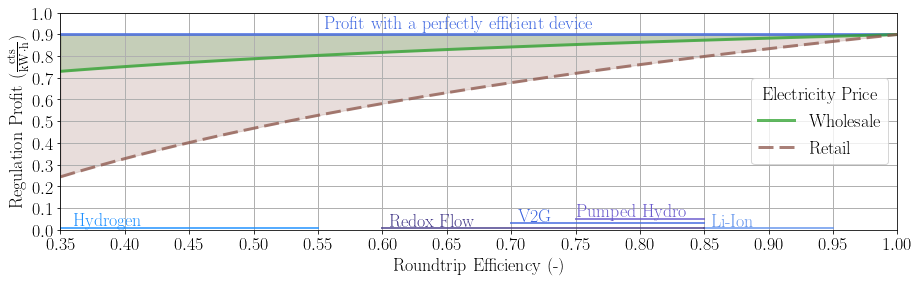

In [22]:
transp = 0.75
transp_fill = 0.2
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)
# Plot
fig = plt.figure(figsize=[15, 4])
plt.rcParams.update({'font.size': 18})
# - baseline
plt.plot([0.35, 1], [100*wholesale_mean[-1], 100*wholesale_mean[-1]], alpha = transp, color = 'RoyalBlue', linewidth = 3)
plt.annotate('Profit with a perfectly efficient device', (0.555, 0.925), color = 'RoyalBlue')
# plt.plot([0.35, 1], [100*wholesale_mean[-1], 100*wholesale_mean[-1]], alpha = transp, color = 'tab:gray', linewidth = 3)
# Distributions
# - wholesale
plt.fill_between(N, 100*wholesale_mean, 100*wholesale_mean[-1]*np.ones(len(N)), alpha = transp_fill, color = 'tab:green')
plt.plot(N, 100*wholesale_mean, linewidth = 3, alpha = transp, label = 'Wholesale', color = 'tab:green')
# - retail
plt.fill_between(N, 100*retail_mean, 100*wholesale_mean[-1]*np.ones(len(N)), alpha = transp_fill, color = 'tab:brown')
plt.plot(N, 100*retail_mean, linewidth = 3, linestyle = (0, (5,2)), alpha = transp, label = 'Retail', color = 'tab:brown')
# Technologies
# Li-Ion
plt.plot([0.85, 0.95], [0.01, 0.01], linewidth = 2, alpha = transp, color = 'cornflowerblue')
plt.annotate('Li-Ion', (0.855, 0.02), color = 'cornflowerblue')
# PHS
plt.plot([0.75, 0.85], [0.05, 0.05], linewidth = 2, alpha = transp, color = 'slateblue')
plt.annotate('Pumped Hydro', (0.75, 0.06), color = 'slateblue')
# V2G
plt.plot([0.70, 0.85], [0.03, 0.03], linewidth = 2, alpha = transp, color = 'royalblue')
plt.annotate('V2G', (0.705, 0.04), color = 'royalblue')
# Redoxflow
plt.plot([0.60, 0.85], [0.01, 0.01], linewidth = 2, alpha = transp, color = 'darkslateblue')
plt.annotate('Redox Flow', (0.605, 0.02), color = 'darkslateblue')
# H2
plt.plot([0.35, 0.55], [0.01, 0.01], linewidth = 2, alpha = transp, color = 'dodgerblue')
plt.annotate('Hydrogen', (0.36, 0.02), color = 'dodgerblue')
# Formatting
plt.grid(linewidth = 1)
plt.xticks(np.arange(0.35, 1.05, 0.05))
plt.yticks(np.arange(0, 1.5, 0.1))
plt.xlabel("Roundtrip Efficiency (-)")
plt.ylabel(r'Regulation Profit $(\frac{\mathrm{cts}}{\mathrm{kW} \cdot \mathrm{h}})$')
plt.legend(title = 'Electricity Price', ncol = 1, loc = 'center right')
plt.axis((0.35, 1, 0, 1))
plt.savefig('Pics/Profit_kW.pdf', bbox_inches = 'tight')

### Compute maximum regulation bid of energy-constrained batteries to construct Figure 8.

Maximum regulation bid for energy-constrained batteries
$$
\bar x^r_\star = \frac{\eta^-}{\frac{\gamma}{T}(1+\eta^+\eta^--m)+m\eta^+\eta^-}\frac{\bar y}{T}
$$
Note that for $\eta^+\eta^- = 1$, the maximum regulation bid is $\frac{T}{\gamma} \frac{\bar y}{2T}$.

In [23]:
def xr_star(nc, nd, gt):
    return nd / ( gt*(1+nc*nd-m(nc*nd)) + m(nc*nd)*nc*nd )

In [24]:
step = 0.01
nvals = np.arange(0.35, 1+step/10, step)
nvals[-1] = int(1)
nnvals = len(nvals)
NC, ND = np.meshgrid(nvals, nvals)

In [25]:
xr_star_01 = np.zeros((nnvals, nnvals))
xr_star_02 = np.zeros((nnvals, nnvals))
for i in range(nnvals):
    for j in range(nnvals):
        nd = nvals[i]
        nc = nvals[j]
        xr_star_01[i][j] = xr_star(nc, nd, 0.1)
        # print('nc: '+str(round(nc,2))+', nd: '+str(round(nd,2))+', xr: '+str(round(xr_star_01[i][j],2)))
        xr_star_02[i][j] = xr_star(nc, nd, 0.2)
# normalize xr_star
xr_star_01_norm = xr_star_01 * 2 * 0.1
xr_star_02_norm = xr_star_02 * 2 * 0.2

In [26]:
# check specific values of xr_star_norm
# gT = 0.1
print('Activation period: 0.1')
print('gamma/T = 0.1, eta^+ = 1, eta^- = 1, xr_max_norm: '+"{:.2f}".format(xr_star_01_norm[-1][-1]))
print('gamma/T = 0.1, eta^+ = 0.35, eta^- = 1, xr_max_norm: '+"{:.2f}".format(xr_star_01_norm[-1][0]))
print('gamma/T = 0.1, eta^+ = 1, eta^- = 0.35, xr_max_norm: '+"{:.2f}".format(xr_star_01_norm[0][-1]))
print('gamma/T = 0.1, eta^+ = 0.35, eta^- = 0.35, xr_max_norm: '+"{:.2f}".format(xr_star_01_norm[0][0]))
# gT = 0.2
print('Activation period: 0.2')
print('gamma/T = 0.2, eta^+ = 1, eta^- = 1, xr_max_norm: '+"{:.2f}".format(xr_star_02_norm[-1][-1]))
print('gamma/T = 0.2, eta^+ = 0.35, eta^- = 1, xr_max_norm: '+"{:.2f}".format(xr_star_02_norm[-1][0]))
print('gamma/T = 0.2, eta^+ = 1, eta^- = 0.35, xr_max_norm: '+"{:.2f}".format(xr_star_02_norm[0][-1]))
print('gamma/T = 0.2, eta^+ = 0.35, eta^- = 0.35, xr_max_norm: '+"{:.2f}".format(xr_star_02_norm[0][0]))
# Specific technologies at gT = 0.2
print('Li-Ion battery, eta^+ = 0.92, eta^- = 0.92, xr_max_norm: '+"{:.2f}".format(xr_star(0.92, 0.92, 0.2) * 2 * 0.2))
print('V2G, eta^+ = 0.88, eta^- = 0.79, xr_max_norm: '+"{:.2f}".format(xr_star(0.88, 0.79, 0.2) * 2 * 0.2))
print('H2, eta^+ = 0.8, eta^- = 0.58, xr_max_norm: '+"{:.2f}".format(xr_star(0.8, 0.58, 0.2) * 2 * 0.2))

Activation period: 0.1
gamma/T = 0.1, eta^+ = 1, eta^- = 1, xr_max_norm: 1.00
gamma/T = 0.1, eta^+ = 0.35, eta^- = 1, xr_max_norm: 1.37
gamma/T = 0.1, eta^+ = 1, eta^- = 0.35, xr_max_norm: 0.48
gamma/T = 0.1, eta^+ = 0.35, eta^- = 0.35, xr_max_norm: 0.61
Activation period: 0.2
gamma/T = 0.2, eta^+ = 1, eta^- = 1, xr_max_norm: 1.00
gamma/T = 0.2, eta^+ = 0.35, eta^- = 1, xr_max_norm: 1.45
gamma/T = 0.2, eta^+ = 1, eta^- = 0.35, xr_max_norm: 0.51
gamma/T = 0.2, eta^+ = 0.35, eta^- = 0.35, xr_max_norm: 0.64
Li-Ion battery, eta^+ = 0.92, eta^- = 0.92, xr_max_norm: 0.98
V2G, eta^+ = 0.88, eta^- = 0.79, xr_max_norm: 0.91
H2, eta^+ = 0.8, eta^- = 0.58, xr_max_norm: 0.77


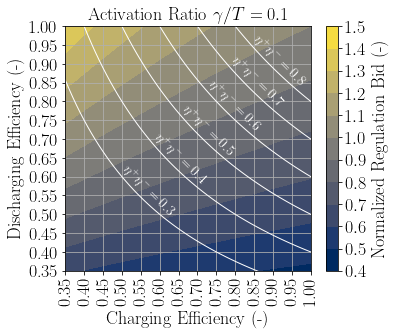

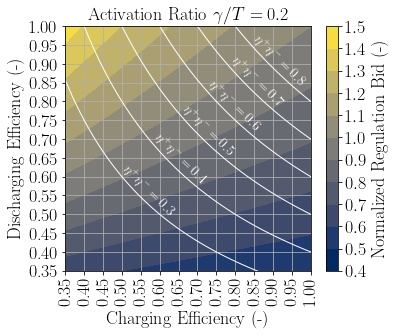

In [27]:
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)

#### gamma/T = 0.1
# Plot
fig = plt.figure(figsize=[5.5, 4.5])
plt.rcParams.update({'font.size': 18})
plt.contourf(NC, ND, xr_star_01_norm, np.arange(0.4, 1.51, 0.1), cmap = 'cividis', origin = 'lower')
# iso-roundtrip efficiency lines
for nc_nd in np.arange(0.3, 0.81, 0.1):
    plt.plot(nvals, nc_nd/nvals, linewidth = 1, color = 'white')
    plt.annotate(r'$\eta^+\eta^-=\,$'+"{:.1f}".format(nc_nd), (np.sqrt(nc_nd)-0.05, np.sqrt(nc_nd)-0.05), \
                 color = 'white', rotation = -45, fontsize = 14)
# Formatting
plt.grid()
plt.colorbar(label = 'Normalized Regulation Bid (-)', ticks = np.arange(0.4, 1.51, 0.1))
y_ticks = np.arange(0.35, 1.05, 0.05)
y_ticks_string = ["{:.2f}".format(round(y, 2)) for y in y_ticks]
plt.xticks(y_ticks, y_ticks_string, rotation = 90)
plt.yticks(y_ticks, y_ticks_string, rotation = 0)
plt.xlabel('Charging Efficiency (-)')
plt.ylabel('Discharging Efficiency (-)')
plt.axis((0.35, 1, 0.35, 1))
plt.title(r'Activation Ratio $\gamma / T = 0.1$', fontsize = 18)
plt.savefig('Pics/xr_max_01.pdf', bbox_inches = 'tight')

#### gamma/T = 0.2
# Plot
fig = plt.figure(figsize=[5.5, 4.5])
plt.rcParams.update({'font.size': 18})
plt.contourf(NC, ND, xr_star_02_norm, np.arange(0.4, 1.51, 0.1), cmap = 'cividis', origin = 'lower')
# iso-roundtrip efficiency lines
for nc_nd in np.arange(0.3, 0.81, 0.1):
    plt.plot(nvals, nc_nd/nvals, linewidth = 1, color = 'white')
    plt.annotate(r'$\eta^+\eta^-=\,$'+"{:.1f}".format(nc_nd), (np.sqrt(nc_nd)-0.05, np.sqrt(nc_nd)-0.05), \
                 color = 'white', rotation = -45, fontsize = 14)
# Formatting
plt.grid()
plt.colorbar(label = 'Normalized Regulation Bid (-)', ticks = np.arange(0.4, 1.51, 0.1))
y_ticks = np.arange(0.35, 1.05, 0.05)
y_ticks_string = ["{:.2f}".format(round(y, 2)) for y in y_ticks]
plt.xticks(y_ticks, y_ticks_string, rotation = 90)
plt.yticks(y_ticks, y_ticks_string, rotation = 0)
plt.xlabel('Charging Efficiency (-)')
plt.ylabel('Discharging Efficiency (-)')
plt.axis((0.35, 1, 0.35, 1))
plt.title(r'Activation Ratio $\gamma / T = 0.2$', fontsize = 18)
plt.savefig('Pics/xr_max_02.pdf', bbox_inches = 'tight')

### Compute expected profit per kWh of energy-constrained storage capacity over one planning horizon to construct Figure 9.
Operating profit in cts/kWh:
$$
100 \cdot \frac{(c^r - c^b m)\eta^-}{\frac{\gamma}{T}(1+\eta^+\eta^- - m)+\eta^+\eta^-m}
$$

In [28]:
def profit_kWh(nc, nd, gt, cr, cb):
    profit = 100*(cr - cb*m(nc*nd))*nd/( gt*(1+nc*nd-m(nc*nd)) + nc*nd*m(nc*nd))
    return profit.mean()

In [29]:
profit_kWh_dict = {}
for market in ['Wholesale', 'Retail']:
    if market == 'Wholesale':
        cb = cb_wholesale
    if market == 'Retail':
        cb = cb_retail
    for gt in [0.1, 0.2]:
        profit_kWh_cand = np.zeros((nnvals, nnvals))
        for i in range(nnvals):
            for j in range(nnvals):
                nd = nvals[i]
                nc = nvals[j]
                profit_kWh_cand[i][j] = profit_kWh(nc, nd, gt, cr, cb)
        cand = market +', '+str(round(gt,1))
        profit_kWh_dict[cand] = profit_kWh_cand

In [30]:
# check specific values of profit_kWh
for market in ['Wholesale', 'Retail']:
    for gt in [0.1, 0.2]:
        cand = market +', '+str(round(gt,1))
        print(cand)
        for nc_idx in [0, nnvals-1]:
            for nd_idx in [0, nnvals-1]:
                print('nc = '+"{:.2f}".format(nvals[nc_idx])+', nd = '+"{:.2f}".format(nvals[nd_idx])+', profit: '+ "{:.2f}".format(profit_kWh_dict[cand][nd_idx][nc_idx]))

Wholesale, 0.1
nc = 0.35, nd = 0.35, profit: 1.71
nc = 0.35, nd = 1.00, profit: 5.01
nc = 1.00, nd = 0.35, profit: 1.75
nc = 1.00, nd = 1.00, profit: 4.49
Wholesale, 0.2
nc = 0.35, nd = 0.35, profit: 0.89
nc = 0.35, nd = 1.00, profit: 2.64
nc = 1.00, nd = 0.35, profit: 0.92
nc = 1.00, nd = 1.00, profit: 2.25
Retail, 0.1
nc = 0.35, nd = 0.35, profit: -1.30
nc = 0.35, nd = 1.00, profit: 1.68
nc = 1.00, nd = 0.35, profit: 0.59
nc = 1.00, nd = 1.00, profit: 4.49
Retail, 0.2
nc = 0.35, nd = 0.35, profit: -0.68
nc = 0.35, nd = 1.00, profit: 0.88
nc = 1.00, nd = 0.35, profit: 0.31
nc = 1.00, nd = 1.00, profit: 2.25


In [31]:
# check practical values of profit_kWh (cts/kWh)
for gt in [0.1, 0.2]:
    print('Activation ratio: '+ "{:.1f}".format(gt))
    print('Ideal, eta^+ = 1, eta^- = 1, retail: '\
          +"{:.2f}".format(profit_kWh(1, 1, gt, cr, cb_retail))\
          +', wholesale: '+"{:.2f}".format(profit_kWh(1, 1, gt, cr, cb_wholesale)))
    print('Li-Ion battery, eta^+ = 0.92, eta^- = 0.92, retail: '\
          +"{:.2f}".format(profit_kWh(0.92, 0.92, gt, cr, cb_retail))\
          +', wholesale: '+"{:.2f}".format(profit_kWh(0.92, 0.92, gt, cr, cb_wholesale)))
    print('V2G, eta^+ = 0.88, eta^- = 0.79, retail: '\
          +"{:.2f}".format(profit_kWh(0.88, 0.79, gt, cr, cb_retail))\
          +', wholesale: '+"{:.2f}".format(profit_kWh(0.88, 0.79, gt, cr, cb_wholesale)))
    print('H2, eta^+ = 0.8, eta^- = 0.58, retail: '\
          +"{:.2f}".format(profit_kWh(0.8, 0.58, gt, cr, cb_retail))\
          +', wholesale: '+"{:.2f}".format(profit_kWh(0.8, 0.58, gt, cr, cb_wholesale)))
# yearly profits with Li-Ion:
print('Yearly profits with Li-Ion (EUR/kWh)')
print('Retail, gt = 0.2: '+"{:.2f}".format(3.65*profit_kWh(0.92, 0.92, 0.2, cr, cb_retail)))
print('Wholesale, gt = 0.1: '+"{:.2f}".format(3.65*profit_kWh(0.92, 0.92, 0.1, cr, cb_wholesale)))

Activation ratio: 0.1
Ideal, eta^+ = 1, eta^- = 1, retail: 4.49, wholesale: 4.49
Li-Ion battery, eta^+ = 0.92, eta^- = 0.92, retail: 3.86, wholesale: 4.23
V2G, eta^+ = 0.88, eta^- = 0.79, retail: 2.98, wholesale: 3.72
H2, eta^+ = 0.8, eta^- = 0.58, retail: 1.55, wholesale: 2.85
Activation ratio: 0.2
Ideal, eta^+ = 1, eta^- = 1, retail: 2.25, wholesale: 2.25
Li-Ion battery, eta^+ = 0.92, eta^- = 0.92, retail: 1.96, wholesale: 2.15
V2G, eta^+ = 0.88, eta^- = 0.79, retail: 1.53, wholesale: 1.92
H2, eta^+ = 0.8, eta^- = 0.58, retail: 0.81, wholesale: 1.49
Yearly profits with Li-Ion (EUR/kWh)
Retail, gt = 0.2: 7.15
Wholesale, gt = 0.1: 15.44


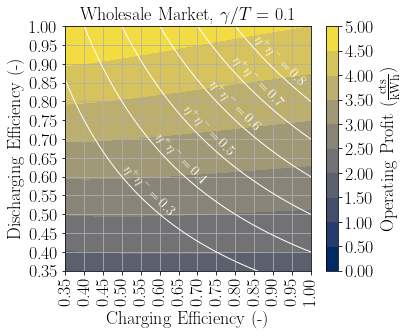

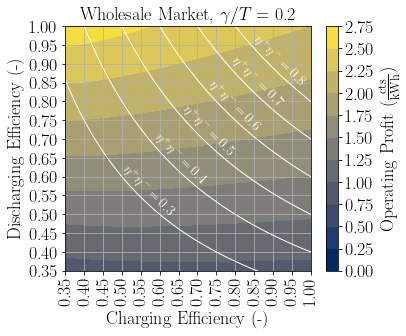

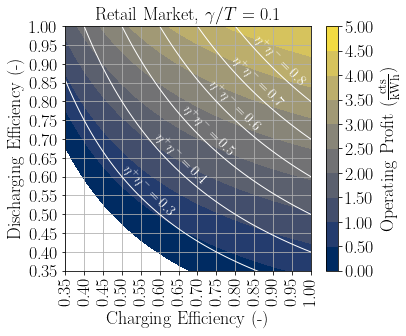

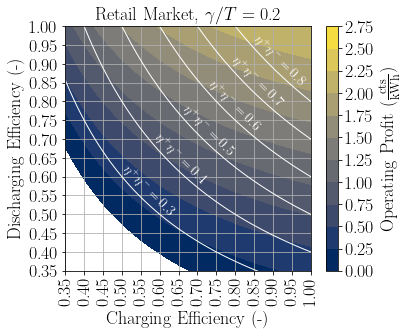

In [32]:
for market in ['Wholesale', 'Retail']:
    for gt in [0.1, 0.2]:
        if gt == 0.1:
            contour_ticks = np.arange(0, 5.4, 0.5)
        if gt == 0.2:
            contour_ticks = np.arange(0, 2.8, 0.25)
        contour_ticks_string = ["{:.2f}".format(round(ct, 2)) for ct in contour_ticks]
        cand = market +', '+str(round(gt,1))
        title_text = market + r' Market, $\gamma / T= \ $'+ "{:.1f}".format(gt)
        fname = 'Pics/Profit_kWh_'+market+'_'+str(round(gt,1))+'.pdf'
        # Plot Defaults
        rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
        rc('text', usetex=True)
        # Plot
        plt.rcParams.update({'font.size': 18})
        fig, ax = plt.subplots(figsize=[5.5, 4.5])
        plt.contourf(NC, ND, profit_kWh_dict[cand], contour_ticks, cmap = 'cividis', origin = 'lower')
        # iso-roundtrip efficiency lines
        for nc_nd in np.arange(0.3, 0.81, 0.1):
            plt.plot(nvals, nc_nd/nvals, linewidth = 1, color = 'white')
            plt.annotate(r'$\eta^+\eta^-=\,$'+"{:.1f}".format(nc_nd), (np.sqrt(nc_nd)-0.05, np.sqrt(nc_nd)-0.05), \
                         color = 'white', rotation = -45, fontsize = 14)
        # Formatting
        plt.grid()
        cbar = plt.colorbar(label = r'Operating Profit $(\frac{\mathrm{cts}}{\mathrm{kWh}})$', ticks = contour_ticks)
        cbar.ax.set_yticklabels(contour_ticks_string)  # vertically oriented colorbar
        y_ticks = np.arange(0.35, 1.05, 0.05)
        y_ticks_string = ["{:.2f}".format(round(y, 2)) for y in y_ticks]
        plt.xticks(y_ticks, y_ticks_string, rotation = 90)
        plt.yticks(y_ticks, y_ticks_string, rotation = 0)
        plt.xlabel('Charging Efficiency (-)')
        plt.ylabel('Discharging Efficiency (-)')
        plt.axis((0.35, 1, 0.35, 1))
        plt.title(title_text, fontsize = 18)
        plt.savefig(fname, bbox_inches = 'tight')

### Compute the effective yearly profits per kWh of storage capacity for a lithium-ion battery to construct Figure 5.

In [33]:
# compute the minimum C-rate for the battery to be energy-constrained
def crate(nc, nd, gt, T):
    return (1+m(nc*nd))*nd / T /(gt*(1+nc*nd-m(nc*nd))+nc*nd*m(nc*nd))

In [34]:
# Investment costs in EUR
EUR2USD = 1.15
c_kWh_low = 85/EUR2USD
c_kWh_high = 165/EUR2USD
c_kW_low = 710/EUR2USD
c_kW_high = 860/EUR2USD
# Lifetime in years
l_kWh = 10
l_kW = 30
# interest rate
r = 0.02

In [35]:
def annualize(c,l,r):
    return c*r*(1+r)**l/( (1+r)**l - 1 )

In [36]:
# annualize investments
a_kWh_low = annualize(c_kWh_low, l_kWh, r)
a_kWh_high = annualize(c_kWh_high, l_kWh, r)
a_kW_low = annualize(c_kW_low, l_kW, r)
a_kW_high = annualize(c_kW_high, l_kW, r)
print('Annualized costs: '+"{:.2f}".format(a_kWh_low)+'-'+"{:.2f}".format(a_kWh_high)+' EUR/kWh, '\
     +"{:.2f}".format(a_kW_low)+'-'+"{:.2f}".format(a_kW_high)+' EUR/kW')

Annualized costs: 8.23-15.97 EUR/kWh, 27.57-33.39 EUR/kW


In [37]:
# calculate yearly profits as a function of T for low and high investment costs and for gT = 0.1 and 0.2
T = np.arange(2, 25)
nc = 0.92
nd = 0.92
cb = cb_wholesale
yearly_profits_kWh = pd.DataFrame(columns =['low_0.1', 'high_0.1', 'low_0.2', 'high_0.2'] , index = T)
for T in yearly_profits_kWh.index:
    for gt in [0.1, 0.2]:
        for inv_cost in ['low', 'high']:
            # compute annualized investment costs
            if inv_cost == 'low':
                a_cost_kWh = a_kWh_low + crate(nc, nd, gt, T) * a_kW_low
            if inv_cost == 'high':
                a_cost_kWh = a_kWh_high + crate(nc, nd, gt, T) * a_kW_high
            # compute yearly operating profit in EUR
            a_profit_kWh = 3.65*profit_kWh(nc, nd, gt, cr, cb)*24/T
            # assign yearly net profit considering investment costs
            cname = inv_cost+'_'+"{:.1f}".format(gt)
            yearly_profits_kWh.loc[T, cname] = a_profit_kWh - a_cost_kWh

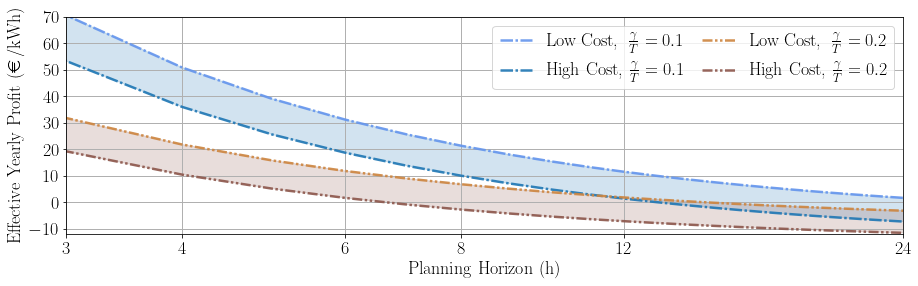

In [38]:
transp = 0.9
transp_fill = 0.2
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{eurosym}')
# Plot
fig = plt.figure(figsize=[15, 4])
plt.rcParams.update({'font.size': 18})
# Distributions
# - activation ratio: 0.1
plt.semilogx(yearly_profits_kWh['low_0.1'], base = 2, linewidth = 2.5, alpha = transp, linestyle = (0, (5, 1, 1, 1)), label = r"Low Cost, $\: \frac{\gamma}{T} = 0.1$", color = 'cornflowerblue')
plt.semilogx(yearly_profits_kWh['high_0.1'], base = 2, linewidth = 2.5, alpha = transp, linestyle = (0, (5, 1, 1, 1)), label = r"High Cost, $\frac{\gamma}{T} = 0.1$", color = 'tab:blue')
plt.fill_between(yearly_profits_kWh.index.tolist(), yearly_profits_kWh['high_0.1'].tolist(), yearly_profits_kWh['low_0.1'].tolist(), alpha = transp_fill, color = 'tab:blue')
# - activation ratio: 0.2
plt.semilogx(yearly_profits_kWh['low_0.2'], base = 2, linewidth = 2.5, alpha = transp, linestyle = (0, (4, 1, 1, 1, 1, 1)), label = r"Low Cost, $\: \frac{\gamma}{T} = 0.2$", color = 'peru')
plt.semilogx(yearly_profits_kWh['high_0.2'], base = 2, linewidth = 2.5, alpha = transp, linestyle = (0, (4, 1, 1, 1, 1, 1)), label = r"High Cost, $\frac{\gamma}{T} = 0.2$", color = 'tab:brown')
plt.fill_between(yearly_profits_kWh.index.tolist(), yearly_profits_kWh['high_0.2'].tolist(), yearly_profits_kWh['low_0.2'].tolist(), alpha = transp_fill, color = 'tab:brown')
# Formatting
plt.grid(linewidth = 1)
x_ticks = [2, 3, 4, 6, 8, 12, 24]
x_ticks_string = ["{:.0f}".format(x) for x in x_ticks]
plt.xticks(x_ticks, x_ticks_string)
y_ticks = np.arange(-20, 130, 10)
plt.yticks(y_ticks)
plt.xlabel("Planning Horizon (h)")
plt.ylabel('Effective Yearly Profit (\EUR/kWh)')
plt.legend(ncol = 2, columnspacing = 1, handlelength = 1.8)
plt.axis((3, 24, -12, 70))
plt.savefig('Pics/profits_T.pdf', bbox_inches = 'tight')

### Compute the power flow distribution to construct Figure 1.

In [39]:
def f_logistic(x, mu, MAD = MAD):
    theta = 2*np.log(2)/MAD
    return theta * np.exp(-theta*(x-mu))/(1 + np.exp(-theta*(x-mu)))**2
def g_logistic(xb, xr, nc, nd, MAD = MAD):
    N = 401
    x = []
    y = [] 
    for i in np.linspace(xb - xr, xb + xr, N):
        y.append(f_logistic(i, xb, xr*MAD))
        if (xb - xr)*(xb + xr) < 0:
            if i <= 0:
                x.append(i/nd)
            else:
                x.append(nc*i)
        else:
            if xb <= 0:
                x.append(i/nd)
            else:
                x.append(nc*i)
    # transform to numpy arrays
    x = np.array(x)
    y = np.array(y)
    # calculate expectation
    xe = sum(x*y)/sum(y)
    return {'x': x, 'y': y, 'xe': xe}

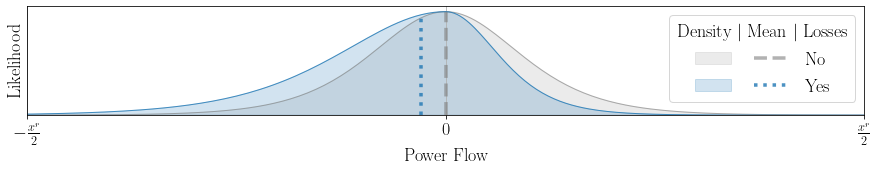

In [40]:
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)
# Plot layout
fig = plt.figure(figsize=[15, 2])
plt.rcParams.update({'font.size': 18})
transp_new = 0.8
transp_middle = 0.6
transp_old = 0.4
transp_fill_new = 0.2
transp_fill_middle = 0.15
# Plot data
# - no losses
xr = 1
xb = 0
nc = 1
nd = 1
# compute results
res = g_logistic(xb, xr, nc, nd)
plt.plot(res['x'], res['y'], alpha = transp_middle, linewidth = 1, color = 'tab:gray')
den0 = plt.fill_between(res['x'], np.zeros(len(res['x'])), res['y'], alpha = transp_fill_middle, color = 'tab:gray', label = ' ')
mean0, = plt.plot([res['xe'], res['xe']], [0, max(res['y'])], alpha = transp_middle, linewidth = 3.5, color = 'tab:gray', linestyle = 'dashed', label = 'No')
# - with losses
xr = 1
xb = 0
nc = 0.7
nd = 0.7
# compute results
res = g_logistic(xb, xr, nc, nd)
plt.plot(res['x'], res['y'], alpha = transp_new, linewidth = 1, color = 'tab:blue')
den1 = plt.fill_between(res['x'], np.zeros(len(res['x'])), res['y'], alpha = transp_fill_new, color = 'tab:blue', label = ' ')
mean1, = plt.plot([res['xe'], res['xe']], [0, 0.975*max(res['y'])], alpha = transp_new, linewidth = 3.5, color = 'tab:blue', linestyle = 'dotted', label = 'Yes')
# More layout
plt.xlim(-xr/2, xr/2)
plt.xticks([-xr/2, 0, xr/2], (r'$-\frac{x^r}{2}$', '0', r'$\frac{x^r}{2}$'))
plt.yticks([])
plt.ylim([0, None])
plt.xlabel('Power Flow')
plt.ylabel('Likelihood')
plt.legend([den0, den1, mean0, mean1], [' ', ' ', 'No', 'Yes'], loc = 'upper right', ncol = 2, title = r'Density $\vert$ Mean $\vert$ Losses', columnspacing = 0.5)
plt.grid()
# Save figure
fig.savefig('Pics/ptb_with_losses.pdf',bbox_inches='tight')

### Compute the feasible set to construct Figure 2.

In [41]:
# empirical MAD calculated on 2017, 2018, 2019 data
MAD = 0.0816*5
# numerical solution with sigmoid approximation
def F(x, MAD = MAD):
    theta = 2*np.log(2)/MAD
    return 1/(1 + np.exp(-theta*x))
def phi(z, MAD = MAD):
    theta = 2*np.log(2)/MAD
    return np.log(1 + np.exp(theta*z))/theta
def m(n, tol = 1e-9):
    # find the root of this function
    def h(z):
         return (1/n - 1) * phi(-z) - z
    # with bisection
    return sopt.bisect(h, 0, 1, xtol = tol)
# ystar for energy constrained batteries
def ystar(m, nc, nd, gamma, T, ybar):
    return (1-m)*ybar / ( 1 + nc * nd + (nc * nd * T/gamma - 1)*m )
# xb to achieve ystar when xr = 0
def xb0(y0, ystar, nc, nd, T):
    return max((ystar - y0)/T, 0)/nc + nd*min((ystar - y0)/T, 0)
# implicit function by bisection
def g(xr, nc, nd, m, ystar, y0, T, tol = 1e-7):
    if y0 == ystar:
        return m*xr
    else:
        # if xr = 0
        xb_0 =  xb0(y0, ystar, nc, nd, T)
        if xr == 0:
            return xb_0
        elif xr <= abs(xb_0):
            return xb_0
        else:
            # loss parameter
            dn = 1/nd - nc
            # find the root of this function
            def h(xb):
                return nc*xb - dn*xr * phi( - xb/xr ) - (ystar - y0)/T
            # with bisection
            return sopt.bisect(h, xb_0, xb_0 + m*xr, xtol = tol)
# maximum regulation bid
def xrmax(yc, yd, y0, ybar, nc, nd, gamma, T):
    return min( (yc + yd)/2, (yc + nd/gamma*y0)/2, (T*yc + nd*y0)/(gamma + T), 
               (yd + (ybar - y0)/(nc*gamma))/2, (T * yd + (ybar - y0)/nc)/(gamma + T),
               (ybar + (nc*nd*T/gamma - 1)*y0)/(nc*(gamma + T)),
               (T/gamma * ybar - (T/gamma - nc*nd)*y0)/(nc*(gamma + T))
              )
# lower bound on xb
def l(xr, y0, yd, nd, gamma, T):
    return max(xr - min(yd, nd*y0/gamma), gamma/T*xr - nd*y0/T)
def xrl(y0, yd, nd, gamma, T):
    return (min(yd, nd*y0/gamma) - nd*y0/T)/(1 - gamma/T)
# upper bound on xb
def u(xr, y0, yc, ybar, nc, gamma, T):
    return min(min(yc, (ybar - y0)/(nc*gamma)) - xr, (ybar - y0)/(nc*T) - gamma/T*xr)
def xru(y0, yc, ybar, nc, gamma, T):
    return (min(yc, (ybar - y0)/(nc*gamma)) - (ybar - y0)/(nc*T))/(1 - gamma/T)
# price impacts
def crx(cr, xr):
    return 1.30 * cr - 0.60 * cr * xr/10
def cbx(cb, xb):
    return cb + 0.20 * cb * xb/10

In [42]:
# input parameters
nc = 0.707
nd = 0.707
gamma = 5
T = 24
ybar = 100
yc = 6
yd = 6
N = 500 # sample points
tol = 1e-5
# Economic parameters
cr = 0.9 # cts/kW/h -- average price of frequency regulation
cb = 4*0.9 #cts/kW/h -- average wholesale electricity market price

# auxiliary parameters
_m = m(nc * nd)
_ystar = ystar(_m, nc, nd, gamma, T, ybar)
ylow = _ystar/2
yhigh = _ystar + (ybar - _ystar)/2

# outputs
results = {}

for y0 in ["ylow", "ystar", "yhigh"]:
    if y0 == "ylow":
        _y0 = ylow
    elif y0 == "ystar":
        _y0 = _ystar
    elif y0 == "yhigh":
        _y0 = yhigh
    df = pd.DataFrame(columns = ["xr", "xb", "profit", "profit_price_effect"])
    _xrmax = xrmax(yc, yd, _y0, ybar, nc, nd, gamma, T)
    _xru = xru(_y0, yc, ybar, nc, gamma, T)
    _xrl = xrl(_y0, yd, nd, gamma, T)
    _xbu = [u(0, _y0, yc, ybar, nc, gamma, T), 
            u(_xru, _y0, yc, ybar, nc, gamma, T),
            u(_xrmax, _y0, yc, ybar, nc, gamma, T)]
    _xbl = [l(0, _y0, yd, nd, gamma, T),
            l(_xrl, _y0, yd, nd, gamma, T),
            l(_xrmax, _y0, yd, nd, gamma, T)]
    # smart sampling
    if y0 == "ystar":
        xr_list = np.linspace(0, _xrmax, N)
    else:
        _xb0 = xb0(_y0, _ystar, nc, nd, T)
        N0 = round(abs(_xb0)/_xrmax * N)
        xr_list = np.r_[np.linspace(0, (1 - 1/N0)*abs(_xb0), N0), np.linspace(abs(_xb0), _xrmax, N)]
    for xr in xr_list:
        # only add new datapoints if we are still feasible
        xb = g(xr, nc, nd, _m, _ystar, _y0, T)
        if (xb > u(xr, _y0, yc, ybar, nc, gamma, T) + tol) or (xb < l(xr, _y0, yd, nd, gamma, T) - tol):
            break
        else:
            df.loc[len(df.index)] = ([xr, xb, T*(cr*xr - cb*xb)/100, T*(crx(cr, xr)*xr - cbx(cb, xb)*xb)/100])
    results[y0] = {'df': df, 'xbl': _xbl, 'xbu': _xbu, 'xrl': _xrl, 'xru': _xru, 'xrmax': _xrmax, 'xb0': _xb0}

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


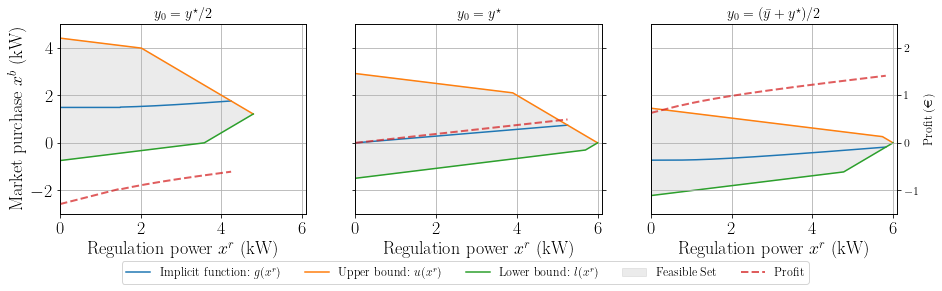

In [43]:
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath, amsfonts, mathtools, eurosym}')
# start new figure
fig, axs = plt.subplots(1,3, figsize=[15, 3.5])
plt.rcParams.update({'font.size': 12})
# iterate over plots
for i in range(3):
    y0 = ["ylow", "ystar", "yhigh"][i]
    ax1 = axs[i]
    # plot xb as a function of xr
    ax1.plot(results[y0]["df"]["xr"], results[y0]["df"]["xb"], label = "Implicit function: $g(x^r)$")
    # plot upper bound on xb
    if results[y0]["xrmax"] <= results[y0]["xru"]:
        xur = [0, results[y0]["xrmax"]]
        xub = [results[y0]['xbu'][0], results[y0]['xbu'][-1]]
    else:
        xur = [0, results[y0]["xru"], results[y0]["xrmax"]]
        xub = results[y0]["xbu"]
    ax1.plot(xur, xub, label = "Upper bound: $u(x^r)$")
    # plot lower bound on xb
    if results[y0]["xrmax"] <= results[y0]["xrl"]:
        xlr = [0, results[y0]["xrmax"]]
        xlb = [results[y0]['xbl'][0], results[y0]['xbl'][-1]]
    else:
        xlr = [0, results[y0]["xrl"], results[y0]["xrmax"]]
        xlb = results[y0]["xbl"]
    ax1.plot(xlr, xlb, label = "Lower bound: $l(x^r)$")
    # gray out feasible set
    ax1.fill(np.r_[xur, xlr[:-1][::-1]], np.r_[xub, xlb[:-1][::-1]], color = "tab:gray", alpha = 0.15, label = "Feasible Set")
    # helper line
    # if y0 == "ylow":
    #     plt.plot([0, results[y0]["xb0"]], [0, results[y0]["xb0"]], color="tab:gray")
    # elif y0 == "yhigh":
    #    plt.plot([0, -results[y0]["xb0"]], [0, results[y0]["xb0"]], color="tab:gray")
    ax1.grid()
    
    if i == 0:
        ax1.set_ylabel("Market purchase $x^b$ (kW)")
        
    ax1.set_xlabel("Regulation power $x^r$ (kW)")
    # plot profit: xb as a function of xr
    ax2 = ax1.twinx()
    ax2.plot(results[y0]["df"]["xr"], results[y0]["df"]["profit"], color = "tab:red", linestyle = "dashed", linewidth = 2, alpha = 0.75, label = "Profit")
    #ax2.plot(results[y0]["df"]["xr"], results[y0]["df"]["profit_price_effect"], color = "tab:purple", linestyle = "dashdot", linewidth = 2, alpha = 1, label = "Profit: elastic prices")
    
    if i == 0:
        fig.legend(loc='lower center', bbox_to_anchor=(.5, -.175), ncol=5)
        ax2.set_yticks([])
        
    if i == 1:
        ax1.set_yticklabels([])
        ax2.set_yticklabels([])
    
    if y0 == "ylow":
        plt.title("$y_0 = y^\star/2$")
    elif y0 == "ystar":
        plt.title("$y_0 = y^\star$")
    elif y0 == "yhigh":
        plt.title(r"$y_0 = (\bar y + y^\star)/2$")
    
    if i == 2:
        ax2.set_ylabel('Profit (\EUR)')
        ax1.set_yticks([])
        ax2.grid()
        
    ax1.set_xlim([0, 6.1])
    ax1.set_ylim([-3, 5])
    ax2.set_ylim([-1.5,2.5])
    
# save figure
plt.savefig('Pics/feasibe_set_inelastic.pdf', bbox_inches = 'tight')

### Load electricity and primary frequency regulation demand and price data to construct Figure 11.

In [44]:
# load electricity consumption in MW
cons = pd.read_excel('conso_mix_RTE_2019.xls', sheet_name = "conso_mix_RTE_2019_modified")
# merge time columns
t = []
for k in range(len(cons.index)):
    t.append(datetime.combine(cons.iloc[k,0].date(), cons.iloc[k,1]))
cons['Time'] = t
cons.drop(columns = ['Journee du', 'Heures'], inplace=True)
cons.set_index('Time', inplace=True)
# Aggregate electricity consumption to hourly resolution
cons = cons.resample('1H').mean()
# load day-ahead price
pb = pd.read_hdf("pd.h5")
# resample to one hour
pb = pb.resample('1H').mean()
# Time frame for comparison
T_jan = pd.date_range('01-01-2019 00:00:00', '01-31-2019 23:00:00', freq='H')
T_jul = pd.date_range('07-01-2019 00:00:00', '07-31-2019 23:00:00', freq='H')
T = T_jan.union(T_jul)
# Dataframe for comparison
df = pd.DataFrame()
df['cons'] = cons['PrevisionJ-1'][T]
df['pb'] = pb['pd'][T]
# Load primary frequency regulation reserves
fname = "ReserveAjustement_2019.xlsx"
reg = pd.read_excel(fname)
# rename columns
reg.columns = reg.iloc[0,:]
# remove first row
reg = reg.iloc[1:]
# consider only primary regulation
reg = reg[reg['Type de réserve']=='Réserve primaire']
# reformat time
t = []
for k in range(len(reg.index)):
    t.append(datetime.combine(reg.iloc[k,0].date(), \
                              datetime.strptime(reg.iloc[k,1][0:5], '%H:%M').time()))
reg['Date'] = t
reg.drop(columns = 'Heures',inplace=True)
reg.rename(columns={'Date': 'Time'}, inplace = True)
# Data Consolidation: convert the price to €/kW/h and keep only the time, price and quantity column
reg = reg[['Time', 'Quantité de la réserve (en MW)', 'Prix de la réserve (en euros/MW/30min)']]
reg.rename(columns={'Prix de la réserve (en euros/MW/30min)': 'pa', 'Quantité de la réserve (en MW)': 'q'}, inplace=True)
reg['pa'] = reg['pa'].apply(lambda x: float(x.replace(',', '.'))*2/1000)
reg['q'] = reg['q'].apply(lambda x: float(x))
# resample to daily resolution
reg = reg.resample('1D', on = 'Time').mean()
# remove missing data
reg_clean = reg.loc[reg.q.isna() == False]

In [45]:
sts.linregress(df.cons, df.pb)

LinregressResult(slope=9.901324931400244e-07, intercept=-0.009312872110545233, rvalue=0.8667619436083814, pvalue=0.0, stderr=1.4778919624386423e-08, intercept_stderr=0.000900593089848232)

In [46]:
df.pb.mean()

0.04928756720430106

In [47]:
sts.linregress(reg_clean.q, reg_clean.pa)

LinregressResult(slope=-1.1226580090266862e-05, intercept=0.014791230901218148, rvalue=-0.3024839053814031, pvalue=4.064162699811754e-09, stderr=1.8618937997073205e-06, intercept_stderr=0.0009718381279618722)

In [48]:
reg.pa.mean()

0.008986501377410467

In [49]:
reg.q.mean()

517.0523415977962

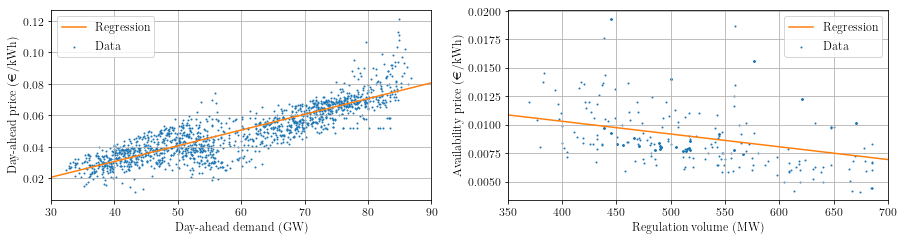

In [50]:
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath, amsfonts, mathtools, eurosym}')
# start new figure
fig, axs = plt.subplots(1,2, figsize=[15, 3.5])
plt.rcParams.update({'font.size': 12})
# iterate over plots
# day-ahead market
ax1 = axs[0]
# data
ax1.scatter(df.cons/1e3, df.pb, s = 1, label = "Data")
# regression
ax1.plot([30, 90], [-0.009312872110545233 + 30/1000, -0.009312872110545233 + 90/1000], color = "tab:orange", label = "Regression")
ax1.set_xlim([30, 90])
ax1.set_xlabel("Day-ahead demand (GW)")
ax1.set_ylabel("Day-ahead price (\EUR/kWh)")
ax1.legend(loc = "upper left")
ax1.grid()
# availability price
ax2 = axs[1]
# data
ax2.scatter(reg.q, reg.pa, s = 1, label = "Data")
# regression
ax2.plot([300, 700], [0.014791230901218148 - 300*1.12e-5, 0.014791230901218148 - 700*1.12e-5], color = "tab:orange", label = "Regression")
ax2.set_xlim([350, 700])
ax2.set_xlabel("Regulation volume (MW)")
ax2.set_ylabel("Availability price (\EUR/kWh)")
ax2.legend(loc = "upper right")
ax2.grid()

# save figure
plt.savefig('Pics/elastic_prices.pdf', bbox_inches = 'tight')